In [1]:
# system imports
import os
import sys

# data science
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import seaborn as sns

# signal processing
from scipy import signal
from scipy.ndimage import label
from scipy.stats import zscore
from scipy.interpolate import interp1d
from scipy.integrate import trapz

# misc
import warnings

In [14]:
os.getcwd()


'c:\\Users\\GauravUgale\\Desktop\\ML_projects'

In [2]:
# style settings
sns.set(style='whitegrid', rc={'axes.facecolor': '#EFF2F7'})

# sample frequency for ECG sensor
settings = {}
settings['fs'] = 500

In [5]:
# data recorded with the ECG sensor
df1 = pd.read_csv("C:\\Users\\GauravUgale\\Desktop\\ML_projects\\All_files_check\\Dharuben_510.csv")

In [7]:
df1

,MLII
0,-0.000319
1,-0.000295
2,-0.000277
3,-0.000271
4,-0.000265
...,...
3745,-0.000538
3746,-0.000439
3747,-0.000394
3748,-0.000304


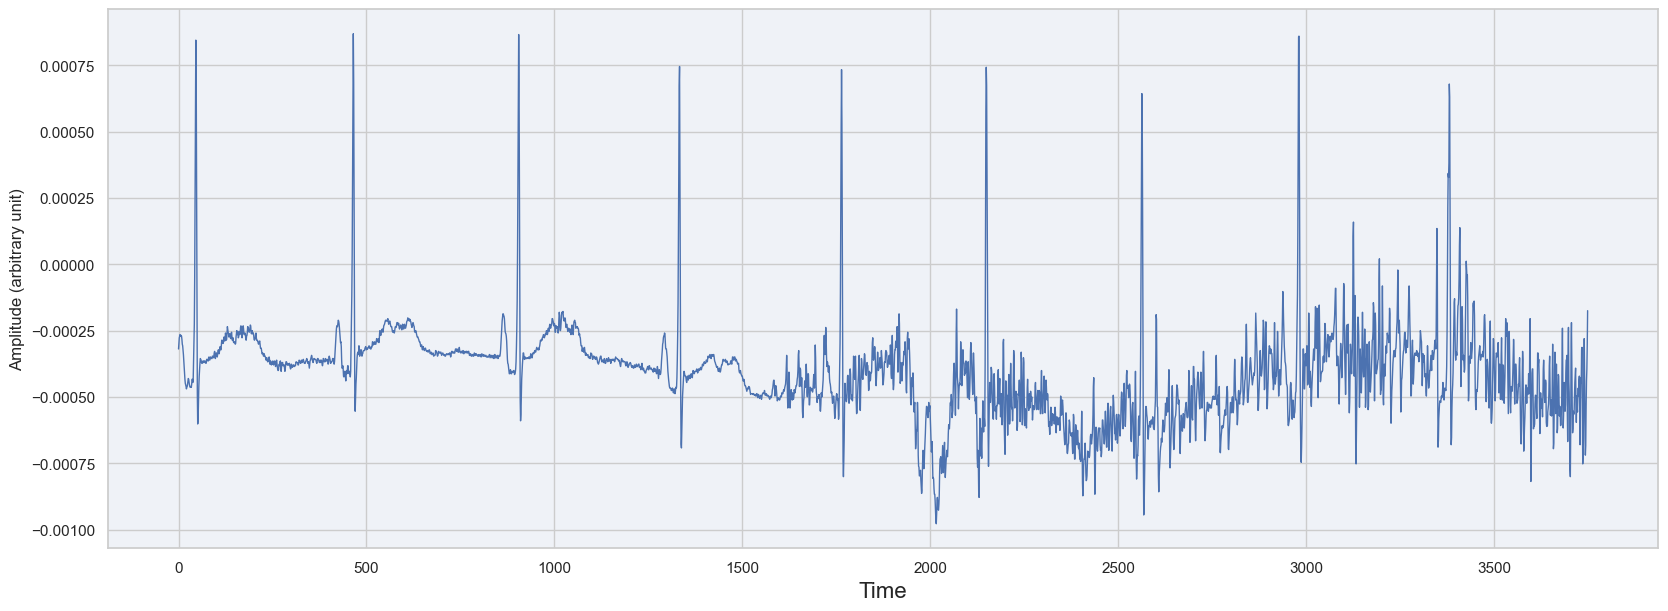

In [8]:
plt.figure(figsize=(20, 7))
start = 0
stop = 10000
duration = (stop-start) / settings['fs']
plt.plot(df1[start:stop].index,df1[start:stop].MLII,linewidth=1)
plt.xlabel("Time", fontsize=16)
plt.ylabel("Amplitude (arbitrary unit)")
plt.show()

In [9]:
def detect_peaks(ecg_signal, threshold=0.3, qrs_filter=None):
    '''
    Peak detection algorithm using cross corrrelation and threshold 
    '''
    if qrs_filter is None:
        # create default qrs filter, which is just a part of the sine function
        t = np.linspace(2.5 * np.pi, 3.5 * np.pi, 30)
        qrs_filter = np.sin(t)
    
    # normalize data
    ecg_signal = (ecg_signal - ecg_signal.mean()) / ecg_signal.std()

    # calculate cross correlation
    similarity = np.correlate(ecg_signal, qrs_filter, mode="same")
    similarity = similarity / np.max(similarity)

    # return peaks (values in ms) using threshold
    return ecg_signal[similarity > threshold].index, similarity


In [10]:
def get_plot_ranges(start=0, end=30, n=5):
    '''
    Make an iterator that divides into n or n+1 ranges. 
    - if end-start is divisible by steps, return n ranges
    - if end-start is not divisible by steps, return n+1 ranges, where the last range is smaller and ends at n
    
    # Example:
    >> list(get_plot_ranges())
    >> [(0.0, 3.0), (3.0, 6.0), (6.0, 9.0)]

    '''
    distance = end - start
    for i in np.arange(start, end, np.floor(distance/n)):
        yield (int(i), int(np.minimum(end, np.floor(distance/n) + i)))

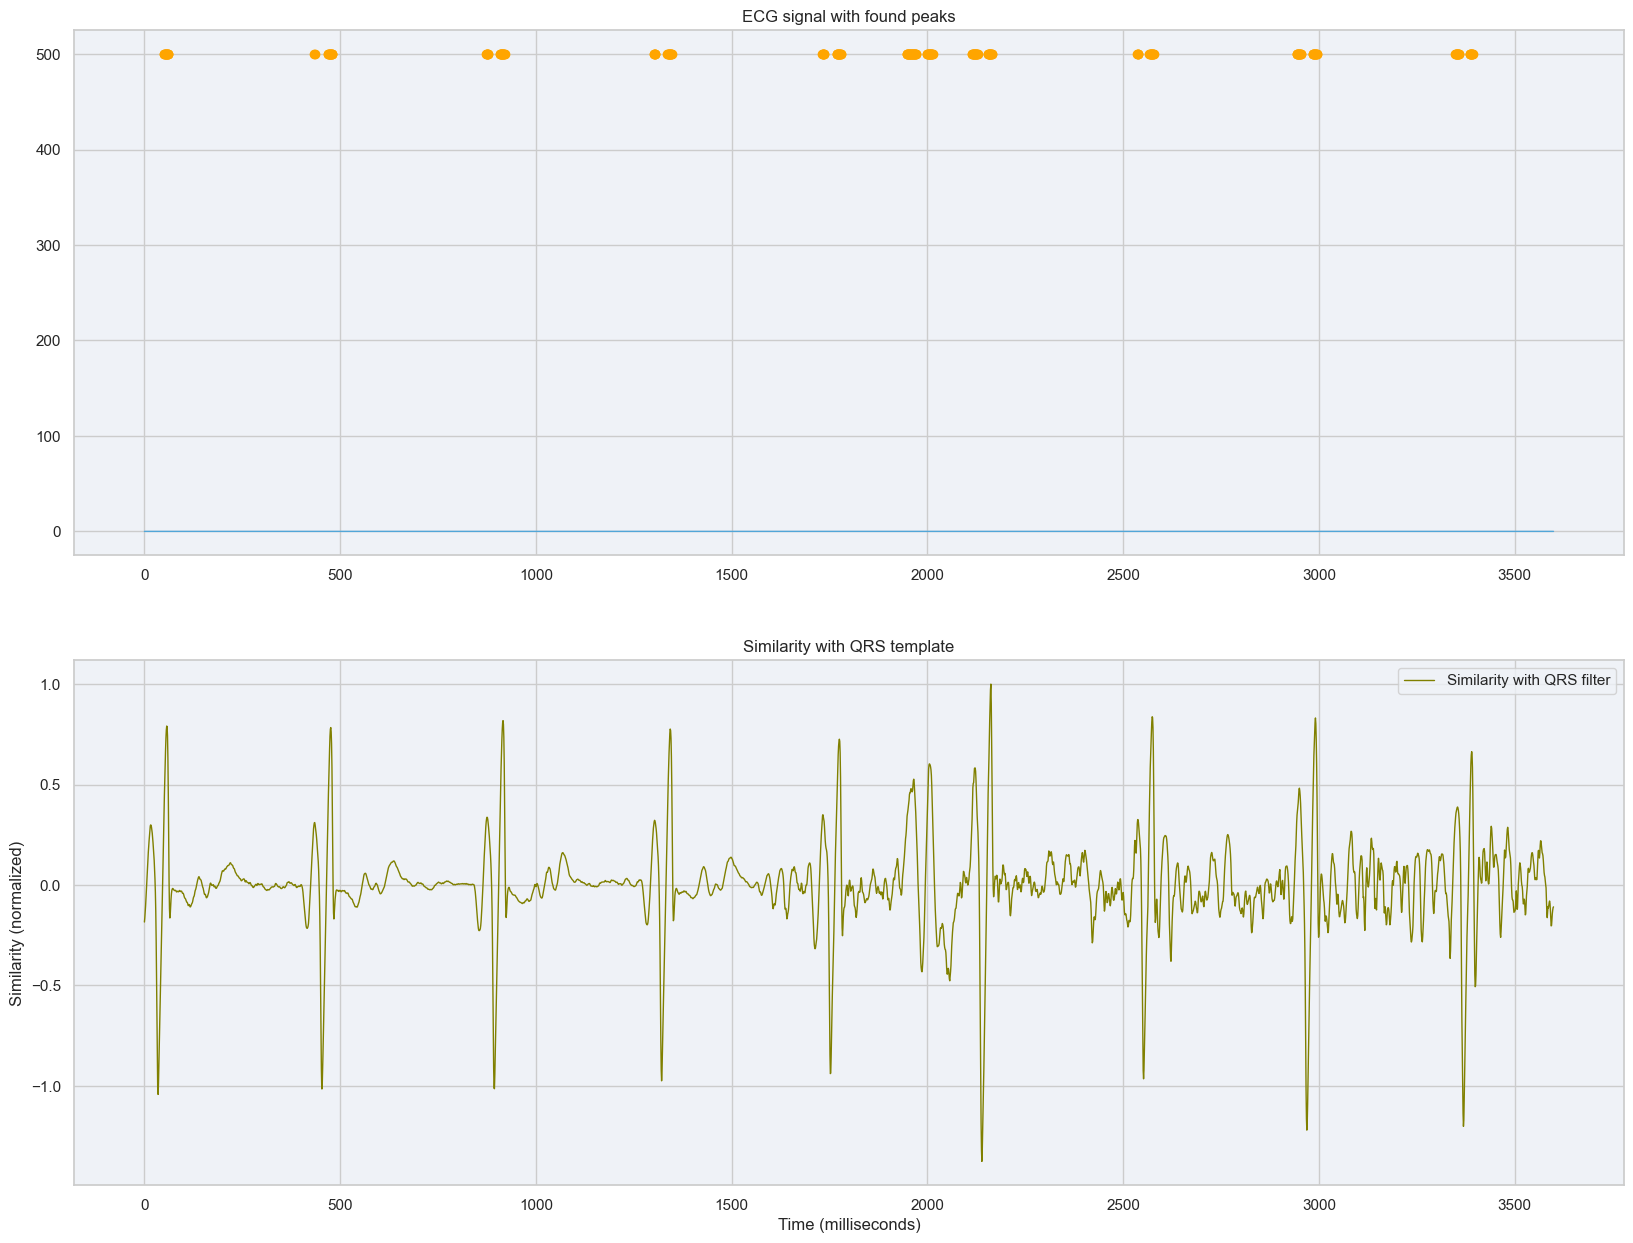

In [11]:
sampfrom = 0
sampto = 3600
nr_plots = 1

for start, stop in get_plot_ranges(sampfrom, sampto, nr_plots):
    # get slice data of ECG data
    cond_slice = (df1.index >= start) & (df1.index < stop) 
    ecg_slice = df1.MLII[cond_slice]

    # detect peaks
    peaks, similarity = detect_peaks(ecg_slice, threshold=0.3)
    
    # plot similarity
    plt.figure(figsize=(20, 15))

    plt.subplot(211)
    plt.title("ECG signal with found peaks")
    plt.plot(ecg_slice.index, ecg_slice, label="ECG", color="#51A6D8", linewidth=1)
    plt.plot(peaks, np.repeat(500, peaks.shape[0]), label="peaks", color="orange", marker="o", linestyle="None")
#     plt.legend(loc="upper right")
#     plt.xlabel("Time (milliseconds)")
#     plt.ylabel("Amplitude (arbitrary unit)")
    
    plt.subplot(212)
    plt.title('Similarity with QRS template')
    plt.plot(ecg_slice.index, similarity, label="Similarity with QRS filter", color="olive", linewidth=1)
    plt.legend(loc="upper right")
    plt.xlabel("Time (milliseconds)")
    plt.ylabel("Similarity (normalized)")

In [12]:
peaks, similarity = detect_peaks(ecg_slice, threshold=0.3)
print(list(peaks))

[50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 434, 435, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 873, 874, 875, 876, 877, 878, 908, 909, 910, 911, 912, 913, 914, 915, 916, 917, 918, 919, 920, 1301, 1302, 1303, 1304, 1305, 1336, 1337, 1338, 1339, 1340, 1341, 1342, 1343, 1344, 1345, 1346, 1347, 1731, 1732, 1733, 1734, 1735, 1736, 1768, 1769, 1770, 1771, 1772, 1773, 1774, 1775, 1776, 1777, 1778, 1779, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2114, 2115, 2116, 2117, 2118, 2119, 2120, 2121, 2122, 2123, 2124, 2125, 2126, 2127, 2128, 2154, 2155, 2156, 2157, 2158, 2159, 2160, 2161, 2162, 2163, 2164, 2165, 2536, 2537, 2538, 2539, 2567, 2568, 2569, 2570, 2571, 2572, 2573, 2574, 2575, 2576, 2577, 2578, 2943, 2944, 2945, 2946, 2947, 2948, 2949, 2950, 2951, 2952, 2953, 2954, 2984, 

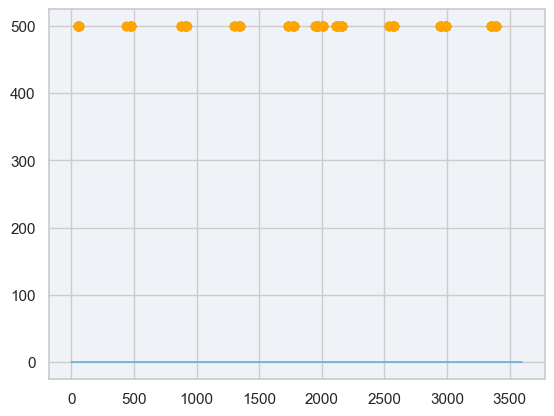

In [13]:
plt.plot(ecg_slice.index, ecg_slice, label="ECG", color="#51A6D8", linewidth=1)
plt.plot(peaks, np.repeat(500, peaks.shape[0]), label="peaks", color="orange", marker="o", linestyle="None")

In [14]:
def group_peaks(p, threshold=3):
    '''
    The peak detection algorithm finds multiple peaks for each QRS complex. 
    Here we group collections of peaks that are very near (within threshold) and we take the median index 
    '''
    # initialize output
    output = np.empty(0)

    # label groups of sample that belong to the same peak
    peak_groups, num_groups = label(np.diff(p) < threshold)

    # iterate through groups and take the mean as peak index
    for i in np.unique(peak_groups)[1:]:
        peak_group = p[np.where(peak_groups == i)]
        output = np.append(output, np.median(peak_group))
    return output

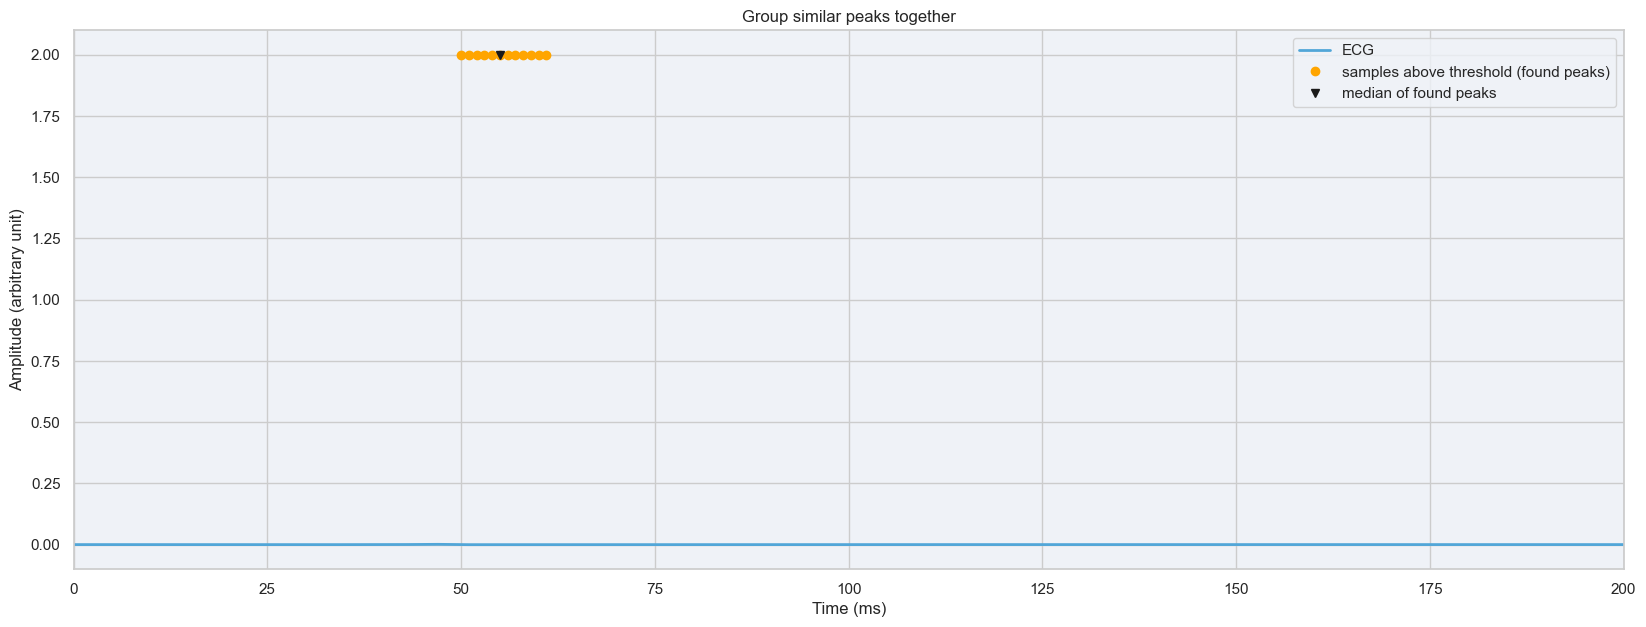

In [15]:
# detect peaks
peaks, similarity = detect_peaks(df1.MLII, threshold=0.3)

# group peaks
grouped_peaks = group_peaks(peaks)

# plot peaks
plt.figure(figsize=(20, 7))
plt.title("Group similar peaks together")
plt.plot(df1.index, df1.MLII, label="ECG", color="#51A6D8", linewidth=2)

plt.plot(peaks, np.repeat(2, peaks.shape[0]),label="samples above threshold (found peaks)", color="orange", marker="o", linestyle="None")
plt.plot(grouped_peaks, np.repeat(2, grouped_peaks.shape[0]), label="median of found peaks", color="k", marker="v", linestyle="None")
plt.legend(loc="upper right")
plt.xlabel("Time (ms)")
plt.ylabel("Amplitude (arbitrary unit)")
plt.gca().set_xlim(0, 200)
plt.show()

In [16]:
q=grouped_peaks
q

array([  55. ,  434. ,  474. ,  875. ,  913.5, 1302.5, 1341. , 1733. ,
       1773. , 1958.5, 2005.5, 2120.5, 2159. , 2537. , 2572. , 2948. ,
       2989. , 3352.5, 3388.5])

In [17]:
# convert numpy array to dataframe
df = pd.DataFrame(q, columns =['A'])
df
 

,A
0,55.0
1,434.0
2,474.0
3,875.0
4,913.5
5,1302.5
6,1341.0
7,1733.0
8,1773.0
9,1958.5


In [1305]:
# using loop
b =[]
for i in range(0, len(q)):
    b.append(int(q[i]))
b

[191, 600, 992, 1381, 1759, 2030, 2158, 2567, 2954]

In [1228]:
t= []
for i in range(len(b)):
    
    f = df1.loc[df1["MLII"].index == b[i]]
    ag= f["MLII"].tolist()
    ag[0] = eval(str(ag[0]))
    t.append(ag)
t


[[0.0],
 [-0.2138271294783069],
 [-0.1976894304176483],
 [-0.1206436935615496],
 [-0.1719040042431442],
 [-0.1819669499928176],
 [-0.1658676324865474],
 [-0.2094865245855382],
 [-0.1069205432035555],
 [-0.2090747951816658],
 [-0.1545380954378758],
 [-0.1433620846065532]]

In [239]:
from datetime import datetime
k = []
# Convert string to datetime.time object
for i in range(len(t)):
    
    time_obj = datetime.strptime(t[i][0], "('%H:%M:%S.%f')").time()
    k.append(time_obj)
k

TypeError: strptime() argument 1 must be str, not float

<!-- from datetime import datetime

start = '1:00.400'
end = '1:01.008'

start_date = datetime.strptime(start, "%M:%S.%f")
end_date = datetime.strptime(end, "%M:%S.%f")

date_difference = end_date-start_date
# date_difference is timedelta object, you can access days as
print(date_difference) -->

In [ ]:
dfk=[]
for i in range(len())

In [ ]:
from datetime import datetime
from datetime import timedelta
g = []
for i in range(len(t)-1):

    t1 = datetime.strptime(t[i][0], "[%H:%M:%S.%f]")
    t2 = datetime.strptime(t[i+1][0], "[%H:%M:%S.%f]")
#     print(t1,t2)
    delta = t2 - t1
    g.append(delta)
    print(delta.seconds,delta.microseconds)\
    

0 985000
0 953000
0 969000
0 945000
0 969000
0 968000
0 993000
0 968000
0 985000


<!-- from datetime import datetime

start = '22:34.850'
end = '22:36.972'

start_date = datetime.strptime(start, "%M:%S.%f")
end_date = datetime.strptime(end, "%M:%S.%f")

date_difference = end_date-start_date
# date_difference is timedelta object, you can access days as
print(date_difference) -->